# ベイズ推論による機械学習入門
## 3.5 線型回帰

### Example

In [32]:
using LinearAlgebra
using Distributions
using Plots
gr()

Plots.GRBackend()

In [33]:
M = 4 # dimensions
N = 20 # sampling data
xmin = 0
xmax = 5
xs = range(xmin, xmax, length=100)
x_sample = xmin .+ (xmax-xmin) .* rand(N)

lambda = 10 # accuracy parameter
dist_epsilon = Normal(0, lambda^(-1))
epsilon = rand(dist_epsilon, N) # noise epsilon

# parameters
m = zeros(M)
l_lambda = Matrix{Float64}(I, M, M)

4×4 Array{Float64,2}:
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0

In [34]:
function polynomial(x)
    return [1.0, x, x^2, x^3]
end

function true_func(x, gain, omega)
    return gain * sin(x * omega)
end

function sampling_y(x, gain, omega, var=1.0)
    dist_y = Normal(true_func(x, gain, omega), var)
    return rand(dist_y, 1)[1]
end

sampling_y (generic function with 2 methods)

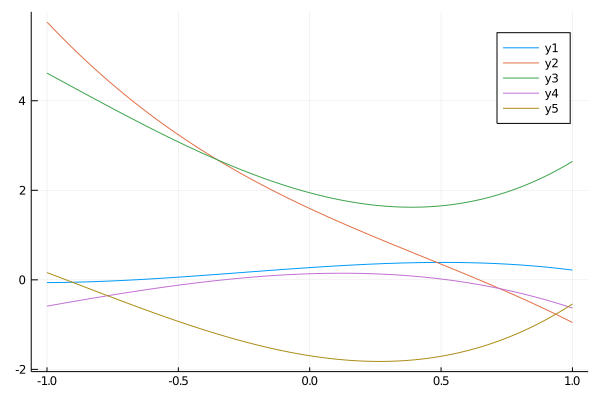

In [35]:
# smapling weight
l_lambda_inv = inv(l_lambda)
ws = rand(MultivariateNormal(m, diag(l_lambda_inv)), 5)'

f(i) = [dot(ws[i, :], polynomial(x)) for x in range(-1, 1, length=1000)]
g() = [f(i) for i in 1:5]

sample_prior = g()
plot(range(-1, 1, length=1000), sample_prior)

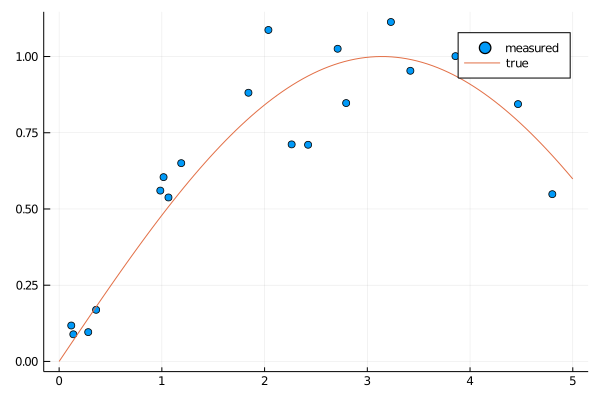

In [36]:
gain = 1
omega = 0.5

# true distribution
f() = [true_func(x, gain, omega) for x in xs]
y_line = f()

# measured data
f() = [sampling_y(x, gain, omega, 1.0/lambda)+epsilon[i] for (i, x) in enumerate(x_sample)]
y_true = f()

plot(x_sample, y_true, seriestype=:scatter, label="measured")
plot!(xs, y_line, label="true")

----
### 事後分布

$$ p(\mathbf{w}|\mathbf{Y},\mathbf{X})=N(\mathbf{w}|\mathbf{\hat{m}},\mathbf{\hat{\Lambda}}^{-1}) $$
$$ \mathbf{\hat{\Lambda}} = \lambda \sum^{N}_{n=1} \mathbf{x}_{n}\mathbf{x}^{\top}_{n} + \mathbf{\Lambda} $$
$$ \mathbf{\hat{m}} = \mathbf{\hat{\Lambda}}^{-1} \lambda (\sum^{N}_{n=1} y_{n}\mathbf{x}_{n} + \mathbf{\Lambda}\mathbf{m}) $$

In [37]:
println("lambda:", lambda)
l_lambda

lambda:10


4×4 Array{Float64,2}:
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0

In [38]:
# calculation large lambda hat
f() = [polynomial(x)*polynomial(x)' for x in x_sample]
sum_x = sum(f())

l_lambda_hat = lambda * sum_x .+ l_lambda
l_lambda_hat_inv = inv(l_lambda_hat)
println("Large lambda hat")
l_lambda_hat

Large lambda hat


4×4 Array{Float64,2}:
  201.0      430.004   1344.98    4821.11
  430.004   1345.98    4821.11   18621.6
 1344.98    4821.11   18622.6    75481.4
 4821.11   18621.6    75481.4   316417.0

In [39]:
# calculation m_hat
f() = [polynomial(x)*y_true[i] for (i, x) in enumerate(x_sample)]
sum_xy = sum(f())
println("sum_xy:", sum_xy)

m_hat = l_lambda_hat_inv * lambda * sum_xy + l_lambda * m
print("m_hat:", m_hat)

sum_xy:[13.543388618403744, 36.045658659998274, 115.26592199996054, 407.6127565330665]
m_hat:[0.05130092094508143, 0.4887917280263423, -0.024181763412606472, -0.010897103189984492]

In [40]:
# calc weight
ws_pred = rand(MultivariateNormal(m_hat, diag(l_lambda_hat_inv)), 5)'

5×4 Adjoint{Float64,Array{Float64,2}}:
 0.055624   0.286458  -0.0332411  -0.0103308
 0.0251748  0.254123   0.0177058  -0.00983607
 0.058459   0.412891  -0.0181554  -0.0103621
 0.0806839  0.579092  -0.0829832  -0.0095294
 0.0578072  0.778586  -0.034631   -0.0113577

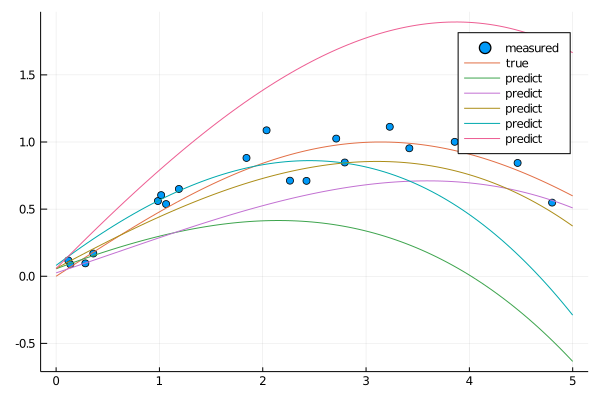

In [41]:
# plot prediction
f(i) = [dot(ws_pred[i, :], polynomial(x)) for x in xs]
g() = [f(i) for i in 1:5]

sample_prior = g()
plot!(xs, sample_prior, label="predict")

----
### 予測分布

$$
p(y_{*}|\mathbf{x_{*}}) = N(y_{*}|\mu_{*},\lambda_{*}^{-1})\\
\mu_{*} = \hat{\mathbf{m}}^{\top}\mathbf{x}_{*} \\
\lambda_{*}^{-1} = \lambda^{-1}+\mathbf{x}_{*}^{\top}\hat{\mathbf{\Lambda}}^{-1}\mathbf{x}_{*}
$$

In [42]:
# μ*
f() = [m_hat' * polynomial(x) for x in xs]
mu_star = f()

# lambda*
function lambda_pred(x, l_lambda_hat_inv, lambda)
    return lambda^(-1) + polynomial(x)' * l_lambda_hat_inv * polynomial(x)
end
f() = [lambda_pred(x, l_lambda_hat_inv, lambda) for x in xs]
var_star = f()
print()

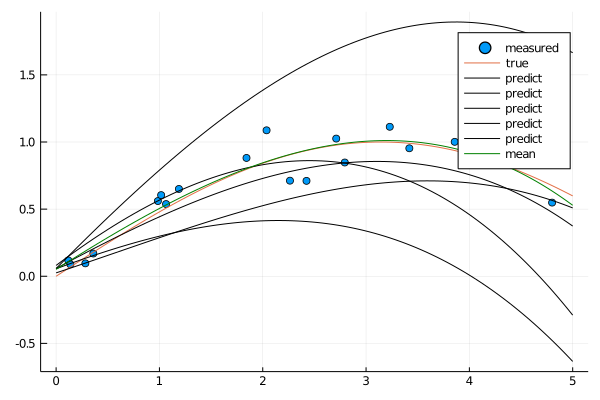

In [43]:
plot(x_sample, y_true, seriestype=:scatter, label="measured")
plot!(xs, y_line, label="true")
plot!(xs, sample_prior, label="predict", color="black")

# mean predicted function
plot!(xs, mu_star, label="mean", color="green")

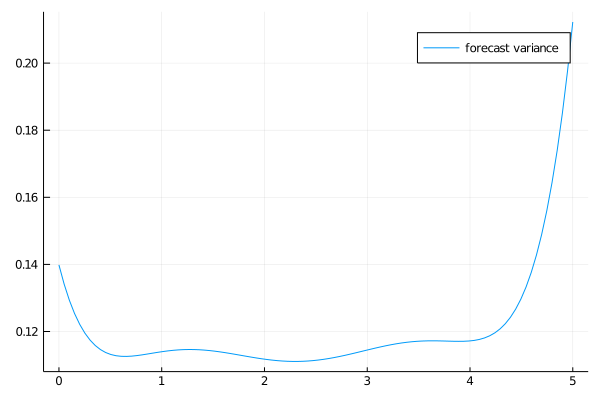

In [44]:
# plotting forecast variance
plot(xs, var_star, label="forecast variance")